## Installation needed

In [1]:
# !pip install tensorflow
# !pip install opencv-python
# !pip install keras

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('dark_background')
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.4.1


## Import files

In [2]:
main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')

In [3]:
from sklearn.model_selection import train_test_split
X = main_data['ImageName']
y = main_data['cellType']

train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.3, random_state = 99)

print("Train data : {}, Test Data: {}".format(train_X.shape[0], test_X.shape[0]))

Train data : 6927, Test Data: 2969


In [5]:
train_Y = train_Y.ravel()
test_Y = test_Y.ravel()

## Transfer to image array

In [6]:
def create_train_data(directory, img_list):
    IMAGE_SIZE = 27
    train_data = []
    for img in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, img)
        img = cv2.resize(cv2.imread(path), (IMAGE_SIZE,IMAGE_SIZE))
        train_data.append(np.array(img))
    print("Successfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [8]:
# CHANGE THE PATH TO IMAGE FOLDER IN YOUR LOCAL DEVICE!
path = r"C:\Users\luong\Documents\GitHub\ML\Asm\ASM2\patch_images"

train_X_img = create_train_data(path, train_X.tolist())
test_X_img = create_train_data(path, test_X.tolist())

Extracting Image Progress: 100%|██████████████████████████████████████████████████| 6927/6927 [00:11<00:00, 611.43it/s]


Successfully import images!


Extracting Image Progress: 100%|██████████████████████████████████████████████████| 2969/2969 [00:04<00:00, 720.54it/s]

Successfully import images!


In [10]:
# Data augmentation
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip = True,
                             rotation_range=20, 
                             shear_range=0.2,  
                             fill_mode='nearest', 
                             width_shift_range=0.2, 
                             height_shift_range=0.2)

In [11]:
train_datagen = datagen.flow(train_X_img, train_Y, 
                             batch_size = 32,
                             shuffle = True)

test_datagen = datagen.flow(train_X_img, train_Y, 
                             batch_size = 32,
                             shuffle = True)

## Construct the CNN model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, BatchNormalization, Dropout

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',activation = 'relu',input_shape=(27,27,3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 27, 27, 64)        1792      
_________________________________________________________________
batch_normalization_12 (Batc (None, 27, 27, 64)        256       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 27, 27, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 27, 27, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_14 (Batc (None, 13, 13, 128)      

In [21]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.000001)
model.compile(optimizer = opt , 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("Custom", 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto')

early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=5, 
                              min_lr=0.001)
EPOCHS = 500
BATCH_SIZE = 16

import time
start_time = time.time()

history = model.fit(train_datagen,
                 validation_data = test_datagen, 
                 batch_size = BATCH_SIZE, 
                 epochs = EPOCHS, 
                 verbose=1,
                 callbacks=[reduce_lr, early, checkpoint])

print("---  Training time in seconds ---%s " % (time.time() - start_time))

Epoch 1/500
217/217 [==============================] - 122s 555ms/step - loss: 1.9566 - accuracy: 0.2578 - val_loss: 1.5544 - val_accuracy: 0.1740
Epoch 2/500
217/217 [==============================] - 120s 552ms/step - loss: 1.8677 - accuracy: 0.2775 - val_loss: 1.7439 - val_accuracy: 0.3992
Epoch 3/500
217/217 [==============================] - 131s 604ms/step - loss: 1.7541 - accuracy: 0.3170 - val_loss: 1.6129 - val_accuracy: 0.4233
Epoch 4/500
217/217 [==============================] - 136s 626ms/step - loss: 1.6902 - accuracy: 0.3357 - val_loss: 1.4521 - val_accuracy: 0.4550
Epoch 5/500
129/217 [================>.............] - ETA: 48s - loss: 1.6558 - accuracy: 0.3630

KeyboardInterrupt: 

In [ ]:
t = time.time()
export = './{}.h5'.format(int(t))
print(export)

model.save(export)

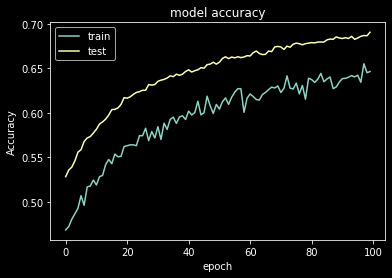

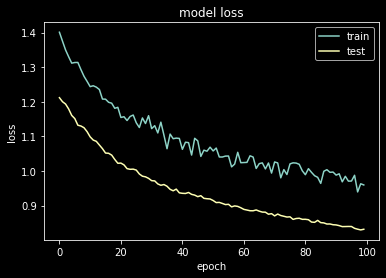

In [81]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Max Test accuracy:', max(history.history['val_accuracy']))
# # visualizing losses and accuracy
print(history.history.keys())
# # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [79]:
from sklearn.metrics import classification_report
pred = model.predict_classes(test_X_img)
pred.reshape(1,-1)[0]
print(classification_report(test_Y, pred))

              precision    recall  f1-score   support

           0       0.66      0.50      0.57       606
           1       0.63      0.71      0.66       840
           2       0.84      0.85      0.84      1334
           3       0.44      0.45      0.45       486

    accuracy                           0.69      3266
   macro avg       0.64      0.63      0.63      3266
weighted avg       0.69      0.69      0.69      3266

